In [2]:
import os
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# -------------------------
# 1) Lire le CSV
# -------------------------
csv_path = "../data/dataset_selection_non_zoomer.csv"
df = pd.read_csv(csv_path)

# Vérifications rapides
assert "path" in df.columns and "label" in df.columns, "Le CSV doit contenir 'path' et 'label'"
df = df.dropna(subset=["path", "label"]).reset_index(drop=True)

# Optionnel: filtrer les fichiers manquants
df["exists"] = df["path"].apply(os.path.exists)
missing = (~df["exists"]).sum()
if missing > 0:
    print(f"[WARN] {missing} fichiers manquants dans le CSV. Je les enlève.")
    df = df[df["exists"]].drop(columns=["exists"]).reset_index(drop=True)
else:
    df = df.drop(columns=["exists"])




In [3]:
# -------------------------
# 2) Encoder les labels
# -------------------------
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# -------------------------
# 3) Split train/val
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["y"] if num_classes > 1 else None
)

# -------------------------
# 4) Dataset + Transforms
# -------------------------
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class FundusDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        y = int(self.df.loc[idx, "y"])

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, y

train_ds = FundusDataset(train_df, transform=train_tfms)
val_ds   = FundusDataset(val_df,   transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# -------------------------
# 5) Modèle (Transfer Learning)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.5)

# -------------------------
# 6) Entraînement + Évaluation
# -------------------------
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

best_val_acc = 0.0
epochs = 10

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    scheduler.step(va_acc)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")


Classes: ['diabete', 'glaucome', 'mda', 'normaux']


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/mathis/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


Epoch 01 | train loss 0.6018 acc 0.7407 | val loss 0.4325 acc 0.8240
  -> saved best_fundus_model.pt
Epoch 02 | train loss 0.4303 acc 0.8085 | val loss 0.3928 acc 0.8388
  -> saved best_fundus_model.pt
Epoch 03 | train loss 0.3597 acc 0.8420 | val loss 0.4086 acc 0.8124
Epoch 04 | train loss 0.3107 acc 0.8662 | val loss 0.5809 acc 0.7628
Epoch 05 | train loss 0.2628 acc 0.8910 | val loss 0.4262 acc 0.8339
Epoch 06 | train loss 0.1915 acc 0.9227 | val loss 0.3530 acc 0.8587
  -> saved best_fundus_model.pt
Epoch 07 | train loss 0.1534 acc 0.9427 | val loss 0.4018 acc 0.8521
Epoch 08 | train loss 0.1231 acc 0.9557 | val loss 0.4062 acc 0.8421
Epoch 09 | train loss 0.1221 acc 0.9551 | val loss 0.4172 acc 0.8397
Epoch 10 | train loss 0.0851 acc 0.9713 | val loss 0.4343 acc 0.8438



=== Confusion Matrix (val) avec labels ===
               Pred_diabete  Pred_glaucome  Pred_mda  Pred_normaux
True_diabete            248              0         2            50
True_glaucome             0            291         0             9
True_mda                  4              0       281            26
True_normaux             64             18        16           201


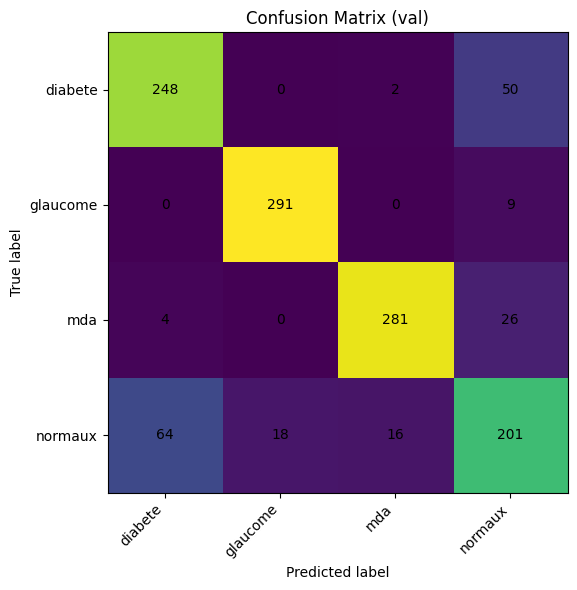


=== Classification report (val) ===
              precision    recall  f1-score   support

     diabete     0.7848    0.8267    0.8052       300
    glaucome     0.9417    0.9700    0.9557       300
         mda     0.9398    0.9035    0.9213       311
     normaux     0.7028    0.6722    0.6872       299

    accuracy                         0.8438      1210
   macro avg     0.8423    0.8431    0.8423      1210
weighted avg     0.8433    0.8438    0.8432      1210



In [8]:
# =========================
# Résultats complets (val) :
# - Matrice de confusion avec NOMS (texte + figure)
# - Classification report
# - AUC (binaire ou multi-classe)
# - Sensibilité / Spécificité (binaire) ou par classe (multi)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import torch

def predict_on_loader(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    y_proba = []  # softmax probabilities

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)

            preds = probs.argmax(dim=1).cpu().numpy()
            y_pred.append(preds)

            y_true.append(y.cpu().numpy())
            y_proba.append(probs.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_proba = np.concatenate(y_proba)  # (N, C)
    return y_true, y_pred, y_proba

def binary_metrics_from_cm(cm):
    # cm = [[TN, FP],
    #       [FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-12)   # TPR / Recall
    spec = tn / (tn + fp + 1e-12)   # TNR
    ppv  = tp / (tp + fp + 1e-12)   # Precision
    npv  = tn / (tn + fn + 1e-12)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    return {"acc": acc, "sens": sens, "spec": spec, "ppv": ppv, "npv": npv}

def multiclass_sens_spec(cm):
    # One-vs-rest sensitivity & specificity per class
    C = cm.shape[0]
    total = cm.sum()
    out = []
    for k in range(C):
        tp = cm[k, k]
        fn = cm[k, :].sum() - tp
        fp = cm[:, k].sum() - tp
        tn = total - tp - fn - fp
        sens = tp / (tp + fn + 1e-12)
        spec = tn / (tn + fp + 1e-12)
        out.append((sens, spec))
    return out

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix (val)"):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # values in cells
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")

    plt.tight_layout()
    plt.show()

# =========================
# UTILISATION (après entraînement)
# =========================

# device, model, val_loader, le, num_classes doivent déjà exister dans ton script

y_true, y_pred, y_proba = predict_on_loader(model, val_loader, device)

# ---- Matrice de confusion + noms (texte)
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{c}" for c in le.classes_],
    columns=[f"Pred_{c}" for c in le.classes_]
)
print("\n=== Confusion Matrix (val) avec labels ===")
print(cm_df)

# ---- Matrice de confusion (figure)
plot_confusion_matrix(cm, class_names=list(le.classes_), title="Confusion Matrix (val)")

# ---- Rapport complet
print("\n=== Classification report (val) ===")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))



In [9]:
import numpy as np
from PIL import Image
def crop_black_border_pil(img: Image.Image, thr=10, pad=10):
    """
    img: PIL RGB
    thr: seuil (0-255). Plus haut => enlève plus (attention à ne pas rogner l'image utile)
    pad: marge ajoutée autour du crop
    """
    arr = np.array(img)  # H,W,3 uint8
    gray = arr.mean(axis=2)  # H,W

    mask = gray > thr  # True = zone utile
    if not mask.any():
        return img  # image totalement sombre -> on ne touche pas

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    # padding + clamp aux bords
    y0 = max(0, y0 - pad)
    x0 = max(0, x0 - pad)
    y1 = min(arr.shape[0] - 1, y1 + pad)
    x1 = min(arr.shape[1] - 1, x1 + pad)

    return img.crop((x0, y0, x1 + 1, y1 + 1))

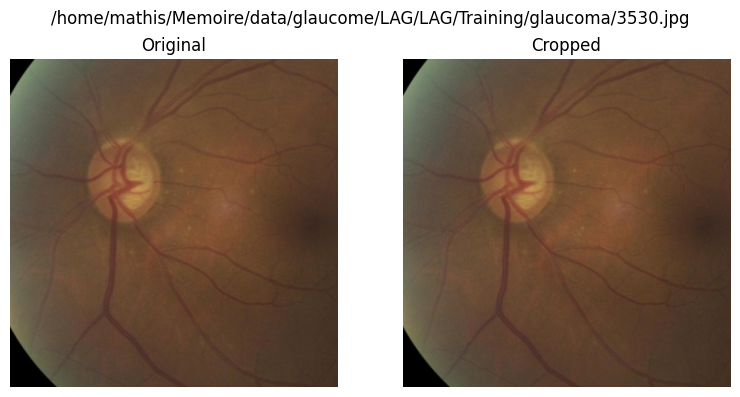

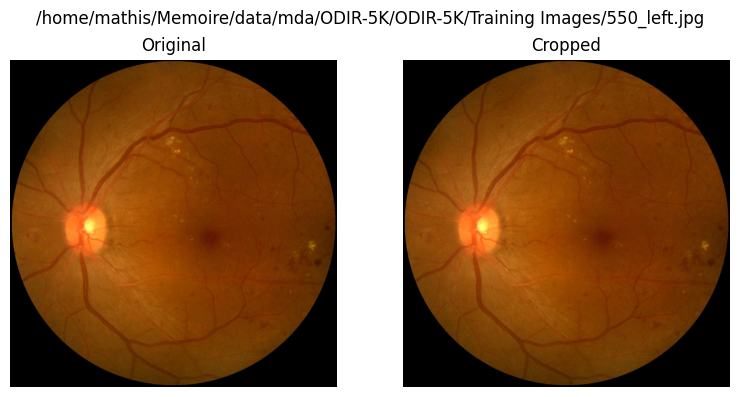

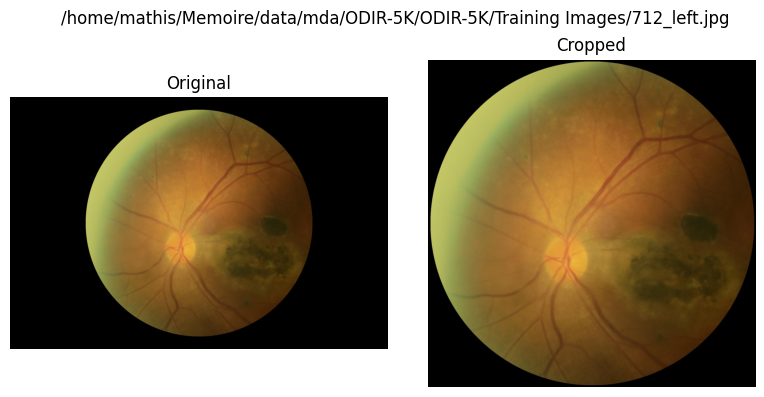

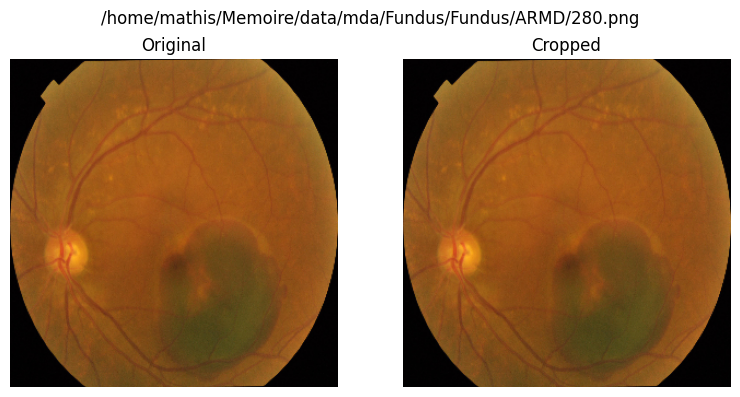

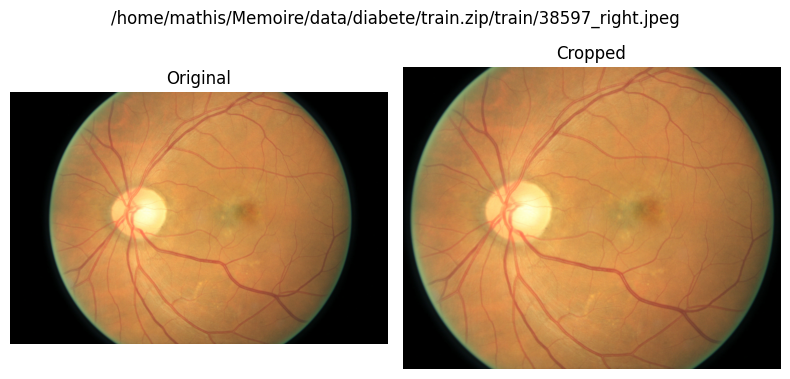

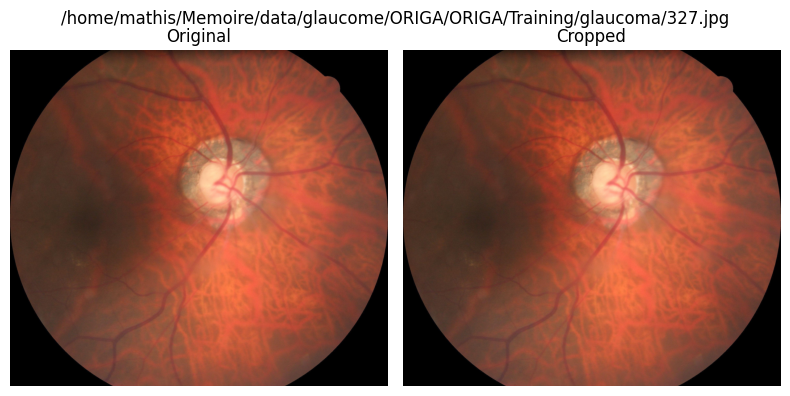

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = df["path"].sample(6, random_state=0).tolist()

for p in sample_paths:
    img = Image.open(p).convert("RGB")
    cropped = crop_black_border_pil(img, thr=10, pad=10)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(cropped)
    axes[1].set_title("Cropped")
    axes[1].axis("off")

    fig.suptitle(p)
    plt.tight_layout()
    plt.show()


In [13]:
# -------------------------
# 2) Encoder les labels
# -------------------------
le = LabelEncoder()
df["y"] = le.fit_transform(df["label"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# -------------------------
# 3) Split train/val
# -------------------------
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["y"] if num_classes > 1 else None
)

# -------------------------
# 4) Dataset + Transforms
# -------------------------
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class FundusDataset(Dataset):
    def __init__(self, dataframe, transform=None, do_crop=True):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.do_crop = do_crop

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        y = int(row["y"])

        img = Image.open(path).convert("RGB")

        if self.do_crop:
            img = crop_black_border_pil(img, thr=10, pad=10)

        if self.transform:
            img = self.transform(img)

        return img, y



train_ds = FundusDataset(train_df, transform=train_tfms)
val_ds   = FundusDataset(val_df,   transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# -------------------------
# 5) Modèle (Transfer Learning)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.5)

# -------------------------
# 6) Entraînement + Évaluation
# -------------------------
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total

best_val_acc = 0.0
epochs = 10

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, val_loader)

    scheduler.step(va_acc)

    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")


Classes: ['diabete', 'glaucome', 'mda', 'normaux']
Epoch 01 | train loss 0.6196 acc 0.7349 | val loss 0.5146 acc 0.7702
Epoch 02 | train loss 0.4310 acc 0.8098 | val loss 0.4211 acc 0.8074
Epoch 03 | train loss 0.3466 acc 0.8559 | val loss 0.4076 acc 0.8273
Epoch 04 | train loss 0.3047 acc 0.8683 | val loss 0.4792 acc 0.8231
Epoch 05 | train loss 0.2612 acc 0.8894 | val loss 0.3958 acc 0.8314
Epoch 06 | train loss 0.2097 acc 0.9140 | val loss 0.5055 acc 0.8033
Epoch 07 | train loss 0.1910 acc 0.9258 | val loss 0.4359 acc 0.8215
Epoch 08 | train loss 0.1593 acc 0.9384 | val loss 0.5744 acc 0.8050
Epoch 09 | train loss 0.1034 acc 0.9642 | val loss 0.4750 acc 0.8331
Epoch 10 | train loss 0.0650 acc 0.9824 | val loss 0.4696 acc 0.8372



=== Confusion Matrix (val) avec labels ===
               Pred_diabete  Pred_glaucome  Pred_mda  Pred_normaux
True_diabete            262              0         3            35
True_glaucome             1            278         0            21
True_mda                  5              1       284            21
True_normaux             72             14        24           189


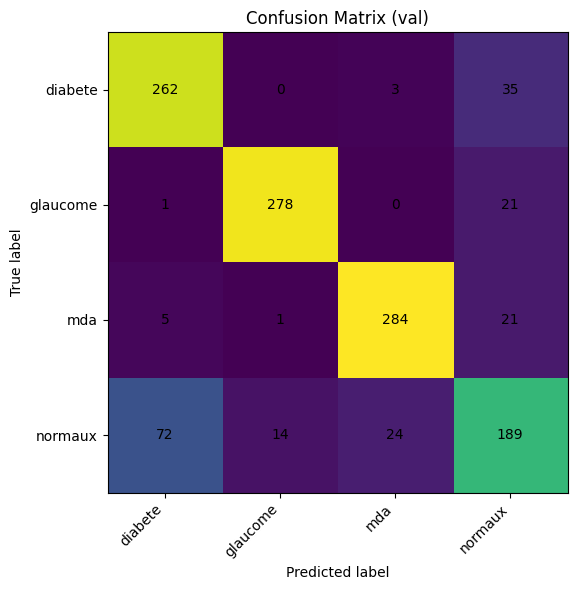


=== Classification report (val) ===
              precision    recall  f1-score   support

     diabete     0.7706    0.8733    0.8187       300
    glaucome     0.9488    0.9267    0.9376       300
         mda     0.9132    0.9132    0.9132       311
     normaux     0.7105    0.6321    0.6690       299

    accuracy                         0.8372      1210
   macro avg     0.8358    0.8363    0.8346      1210
weighted avg     0.8366    0.8372    0.8355      1210



In [14]:
y_true, y_pred, y_proba = predict_on_loader(model, val_loader, device)

# ---- Matrice de confusion + noms (texte)
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{c}" for c in le.classes_],
    columns=[f"Pred_{c}" for c in le.classes_]
)
print("\n=== Confusion Matrix (val) avec labels ===")
print(cm_df)

# ---- Matrice de confusion (figure)
plot_confusion_matrix(cm, class_names=list(le.classes_), title="Confusion Matrix (val)")

# ---- Rapport complet
print("\n=== Classification report (val) ===")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
